# **Used Car Price Predictor Notebook**

### import required libraries

In [1]:
import keras 
import pandas as pd
import pandasql as sqldf
from zip_to_state import zip_to_state, state_to_abbrev
import plotly.express as px
import numpy as np
from scipy import stats
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor


## **Phase 1: Data Collection**
#### **Step 1: Extract Training Data from Parquet File**

In [2]:
# time to run: 4m 57s
df = pd.read_csv('used_cars_data.csv')

C:\Users\Daymo\AppData\Local\Temp\ipykernel_26272\2680727636.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('used_cars_data.csv')


# ---------------------------------------------------------------------------

#### **Step 2: Preview the Dataset's Schema**

In [3]:
pd.reset_option('all')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df.tail(5)
# df.shape
# df.columns


,vin,back_legroom,bed,bed_height,bed_length,body_type,cabin,city,city_fuel_economy,combine_fuel_economy,daysonmarket,dealer_zip,description,engine_cylinders,engine_displacement,engine_type,exterior_color,fleet,frame_damaged,franchise_dealer,franchise_make,front_legroom,fuel_tank_volume,fuel_type,has_accidents,height,highway_fuel_economy,horsepower,interior_color,isCab,is_certified,is_cpo,is_new,is_oemcpo,latitude,length,listed_date,listing_color,listing_id,longitude,main_picture_url,major_options,make_name,maximum_seating,mileage,model_name,owner_count,power,price,salvage,savings_amount,seller_rating,sp_id,sp_name,theft_title,torque,transmission,transmission_display,trimId,trim_name,vehicle_damage_category,wheel_system,wheel_system_display,wheelbase,width,year
3000035,2GNAXJEV0J6261526,39.7 in,NaN,NaN,NaN,SUV / Crossover,NaN,Fairfield,26.0,NaN,16,94533,CarMax Curbside is now available at select sto...,I4,1500.0,I4,Silver,True,False,False,NaN,40.9 in,14.9 gal,Gasoline,False,65.4 in,32.0,170.0,Black,True,NaN,NaN,False,NaN,38.2418,183.1 in,2020-08-27,SILVER,280498781,-122.083,https://static.cargurus.com/images/forsale/202...,"['Alloy Wheels', 'Bluetooth', 'Backup Camera',...",Chevrolet,5 seats,41897.0,Equinox,1.0,NaN,17998.0,False,381,4.272727,341247.0,CarMax Fairfield - Now offering Curbside Picku...,False,NaN,A,Automatic,t72936,1.5T LT FWD,NaN,FWD,Front-Wheel Drive,107.3 in,72.6 in,2018
3000036,1GNERFKW0LJ225508,38.4 in,NaN,NaN,NaN,SUV / Crossover,NaN,Vallejo,18.0,NaN,171,94591,Prices do not include government fees and taxe...,V6,3600.0,V6,Mosaic Black Metallic,NaN,NaN,True,Chevrolet,41 in,19.4 gal,Gasoline,NaN,70.7 in,27.0,310.0,Jet Black,NaN,NaN,NaN,True,NaN,38.1102,204.3 in,2020-03-25,BLACK,269431681,-122.203,https://static.cargurus.com/images/forsale/202...,"['Alloy Wheels', 'Third Row Seating', 'Bluetoo...",Chevrolet,8 seats,5.0,Traverse,NaN,"310 hp @ 6,800 RPM",36490.0,NaN,0,4.533333,310674.0,Team Chevrolet,NaN,"266 lb-ft @ 2,800 RPM",A,Automatic,t85763,LS FWD,NaN,FWD,Front-Wheel Drive,120.9 in,78.6 in,2020
3000037,3FA6P0HD3GR134062,38.3 in,NaN,NaN,NaN,Sedan,NaN,Napa,NaN,NaN,91,94559,Introducing the 2016 Ford Fusion! Offering an ...,NaN,2000.0,NaN,Gray,False,False,True,Jeep,44.3 in,16.5 gal,NaN,True,58.2 in,NaN,240.0,NaN,False,NaN,NaN,False,NaN,38.2873,191.7 in,2020-06-13,GRAY,274044548,-122.275,https://static.cargurus.com/images/forsale/202...,"['Alloy Wheels', 'Bluetooth', 'Backup Camera']",Ford,5 seats,57992.0,Fusion,2.0,"240 hp @ 5,500 RPM",12990.0,False,462,4.142857,389479.0,Hanlees Chrysler Dodge Jeep Ram of Napa,False,"270 lb-ft @ 1,750 RPM",A,6-Speed Automatic Overdrive,t57569,SE,NaN,FWD,Front-Wheel Drive,112.2 in,83.5 in,2016
3000038,SAJAJ4BNXHA968809,35 in,NaN,NaN,NaN,Sedan,NaN,Fairfield,30.0,NaN,11,94533,CarMax Curbside is now available at select sto...,I4 Diesel,2000.0,I4 Diesel,Green,False,False,False,NaN,41.5 in,14.8 gal,Diesel,False,55.7 in,40.0,180.0,Cream,False,NaN,NaN,False,NaN,38.2418,183.9 in,2020-09-01,GREEN,280923167,-122.083,https://static.cargurus.com/images/forsale/202...,"['Sunroof/Moonroof', 'Navigation System', 'All...",Jaguar,5 seats,27857.0,XE,1.0,"180 hp @ 4,000 RPM",26998.0,False,849,4.272727,341247.0,CarMax Fairfield - Now offering Curbside Picku...,False,"318 lb-ft @ 1,750 RPM",A,Automatic,t65977,20d Premium AWD,NaN,AWD,All-Wheel Drive,111.6 in,81.7 in,2017
3000039,JN8AT2MT1HW400805,37.9 in,NaN,NaN,NaN,SUV / Crossover,NaN,Napa,26.0,NaN,17,94559,"Here it is!! In these economic times, a super ...",I4,2500.0,I4,Brilliant Silver,False,False,True,Nissan,43 in,14.5 gal,Gasoline,False,68.1 in,33.0,170.0,NaN,False,NaN,True,False,True,38.2927,184.5 in,2020-08-26,SILVER,280345818,-122.278,https://static.cargurus.com/images/forsale/202...,"['Alloy Wheels', 'Bluetooth', 'Backup Camera',...",Nissan,7 seats,22600.0,Rogue,1.0,"170 hp @ 6,000 RPM",19900.0,False,1203,4.333333,64910.0,Napa Nissan Inc,False,"175 lb-ft @ 4,400 RPM",A,Automatic,t76529,2017.5 SV FWD,NaN,FWD,Front-Wheel Drive,106.5 in,72.4 in,2

# ---------------------------------------------------------------------------

## **MLOPs Phase 2: Data Ingestion**
#### For the purposes of this tutorial, we will not be ingesting data. However, in an organizational setting, you'll use an ingestion framework, such as Apache Airflow, Apache Spark, or Apache Kafka, to collect data into a Data Lake to create a curated Training Dataset.

## **MLOPs Phase 3: Data Storage **
#### Since we already extracted this data was previously extracted from BigQuery, this phase has already been completed. Typically, you'll use a Cloud Storage Bucket (e.g., AWS S3, Google Cloud Storage) to store all data to be used in ML applications.

# ---------------------------------------------------------------------------

## **MLOps Phase 5: Exploratory Data Analysis (EDA)**

#### **Find the total number of missing values per column**

In [ ]:
for col in df.columns:
    # Count rows with NaN as 'mileage'
    nan_mileage_count = df[col].isna().sum()

    # Print the count
    print(f"{col}: {nan_mileage_count}")
    

#### **Catagorical Data Col Analysis**

In [6]:
categorical_columns = ['body_type', 'listing_color','has_accidents','is_new','salvage','wheel_system','make_name','trim_name','frame_damaged','fleet']
#'exterior_color'
unique_value_counts = df[categorical_columns].nunique()

value_frequencies = {}
for col in categorical_columns:
    value_frequencies[col] = df[col].value_counts()

print("Count of Unique Values:")
print(unique_value_counts)


Count of Unique Values:
body_type           9
listing_color      15
has_accidents       2
is_new              2
salvage             2
wheel_system        5
make_name         100
trim_name        9062
frame_damaged       2
fleet               2
dtype: int64


In [7]:
# Loop through categorical columns and create histograms
categorical_columns.remove('fleet')
categorical_columns.remove('frame_damaged')
categorical_columns.remove('trim_name')
categorical_columns.remove('wheel_system')

for col, frequencies in value_frequencies.items():
    fig = px.bar(frequencies, x=frequencies.index, y=frequencies.values, labels={'x': col, 'y': 'Frequency'})
    
    # Customize the layout if needed
    fig.update_layout(
        title=f'Histogram of {col}',
        xaxis_title=col,
        yaxis_title='Frequency',
        xaxis={'categoryorder':'total descending'}  # Sort categories by frequency
    )
    
    fig.show()  

#### **Numerical Data Col Analysis**

In [ ]:

numerical_columns = [ 
       'horsepower','daysonmarket', 'mileage', 'owner_count', 'price','year',] 

summary_statistics = df[numerical_columns].describe()
rounded_summary_statistics = summary_statistics.round(2)  
print(rounded_summary_statistics)


In [ ]:
df = zip2State(df)

In [ ]:

x_range_price = [0, 200000]
x_range_year = [1995, 2022]
x_range_mileage = [0, 100000]

fig_price = px.histogram(df, x='price', title='Price Distribution - Outliers removed', range_x=x_range_price,  nbins=500)
fig_mileage = px.histogram(df, x='mileage', title='Mileage Distribution - Outliers removed', range_x=x_range_mileage,  nbins=32000)
fig_year = px.histogram(df, x='year', title='Year Distribution - Outliers removed', range_x=x_range_year)

state_summary = pd.DataFrame(df['dealer_zip'].astype(str).str[:5])
state_summary['state'] = state_summary['dealer_zip'].astype(int).apply(
    lambda zip_code: next((state for (zipcode_range, state) in zip_to_state.items() if zip_code >= zipcode_range[0] and zip_code <= zipcode_range[1]), 'Unknown')
)
state_summary = state_summary.groupby('state').size().reset_index(name='total_listings')
state_summary['state_abbr'] = state_summary['state'].map(state_to_abbrev)
state_summary = state_summary[state_summary['state_abbr'] != 'Unknown']
max_value = state_summary['total_listings'].max()
fig_map = px.choropleth(
    state_summary,
    locations='state_abbr',  
    locationmode='USA-states',      
    color='total_listings',       
    color_continuous_scale='greens',
    range_color=(0, max_value), 
    scope='usa'                  
)

fig_map.update_geos(fitbounds='locations', visible=False)
fig_map.show()

fig_price.show()
fig_mileage.show()
fig_year.show()


#### **Find total outliers per col and how many standard deviations out**

In [ ]:

# # Assuming df is your DataFrame with columns "mileage," "owner_count," "price," and "year"
columns_of_interest = [ 'mileage', 'year','horsepower','price']
# Initialize a dictionary to store outlier counts for each column
outlier_counts = {}

# Set the Z-score threshold for identifying outliers
z_score_threshold = 20 # You can adjust this threshold as needed

for col in columns_of_interest:
    z_scores = np.abs(stats.zscore(df[col]))
    outliers = (z_scores > z_score_threshold)
    outlier_count = outliers.sum()
    outlier_counts[col] = outlier_count

#Display the counts of outliers for each column
for col, count in outlier_counts.items():
    print(f"{col}: {count} outliers")

# Identify outliers for the "price" column
price_z_scores = np.abs(stats.zscore(df['price']))
price_outliers = (price_z_scores > z_score_threshold)
# Filter the DataFrame to get rows where "price" is an outlier
price_outlier_rows = df[price_outliers]
desired_columns = ['make_name','model_name', 'year', 'mileage', 'price']
price_outlier_rows = price_outlier_rows[desired_columns]
# Print the rows that are outliers for the "price" column
print("Rows where 'price' is an outlier:")
print(price_outlier_rows.sort_values(by='price', ascending=False))

In [ ]:
def custom_format(x):
    if x >= 1e6:
        return '{:.4g} mil'.format(x / 1e6)
    elif x >= 1e3:
        return '{:.4g}k'.format(x / 1e3)
    else:
        return '{:.4g}'.format(x)

# # Apply the custom formatting function to specific columns using applymap
# columns_to_format = ['price', 'daysonmarket','horsepower','mileage','owner_count']  # Add the columns you want to format
# price_outlier_rows[columns_to_format] = price_outlier_rows[columns_to_format].applymap(custom_format)

# Assuming you want to generate summary statistics only for the "price" column
price_outlier_rows[['price']].sort_values(by='price', ascending=False).applymap(custom_format)



#### **Create Correlation Matrix**

               mileage     price      year  horsepower  daysonmarket
mileage       1.000000 -0.274082 -0.470940   -0.015667     -0.049871
price        -0.274082  1.000000  0.355366    0.605404      0.063288
year         -0.470940  0.355366  1.000000    0.028716     -0.001731
horsepower   -0.015667  0.605404  0.028716    1.000000     -0.019621
daysonmarket -0.049871  0.063288 -0.001731   -0.019621      1.000000


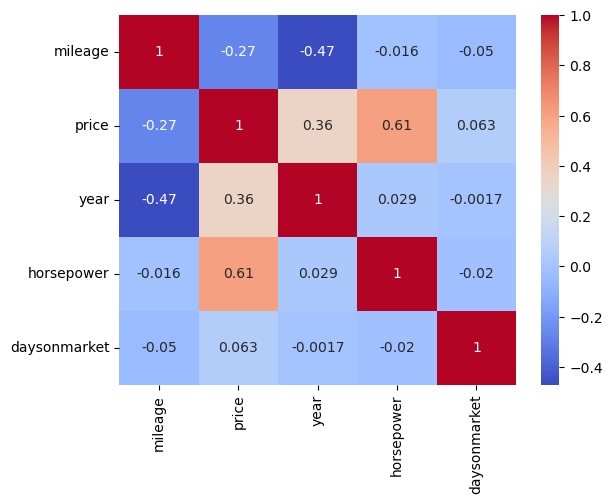

In [8]:
corr_matrix = df[['mileage', 'price', 'year', 'horsepower','daysonmarket']].corr()
print(corr_matrix)
plt = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')


## **DataPipline (Preparation and Wrangling)**

# ---------------------------------------------------------------------------
#### **Step 1: Use Intuition to Remove Irrelevant Features**

In [ ]:
columns_to_be_removed = ['power',"latitude","longitude","city","vin","back_legroom","bed","bed_height","bed_length","cabin","city_fuel_economy","combine_fuel_economy","engine_cylinders","engine_displacement","engine_type","franchise_dealer","franchise_make","front_legroom","fuel_tank_volume","fuel_type","height","highway_fuel_economy","interior_color","isCab","is_certified","is_cpo","is_oemcpo","length","listed_date","listing_id","main_picture_url","maximum_seating","savings_amount","seller_rating","sp_id","sp_name","theft_title","torque","transmission","transmission_display","vehicle_damage_category","wheel_system_display","wheelbase","width",'trimId', 'major_options']
# columns_to_be_removed = ["exterior_color"]
df = df.drop(columns=columns_to_be_removed)

#### **Remove price outliers for each row depending on like make , model and year vehicles**

In [ ]:
import pandas as pd

def get_outliers(group):
    z_scores = stats.zscore(group['price'])
    threshold = 8
    outlier_indices = (z_scores > threshold) | (z_scores < -threshold)
    return group[outlier_indices]
outliers = df.groupby(['make_name', 'model_name', 'year'], group_keys=False).apply(get_outliers)
outliers.reset_index(drop=True, inplace=True)
df = df.drop(outliers.index)
df.reset_index(drop=True, inplace=True)


In [ ]:
filtered_df.shape

In [ ]:
outliers = df.groupby(['make_name', 'model_name', 'year'], group_keys=False).apply(get_outliers)


outliers.sort_values(by='price', ascending=False).head(100)
outliers

#### **Convert all data in each column to target type**

In [ ]:

data_types = {
    'fleet': bool,
    'frame_damaged': bool,
    'has_accidents': bool,
    'is_new': bool,
    'mileage': int,
    'owner_count': int,
    'price': int,
    'salvage': bool,
    'year': int,
}

# Use the astype method to convert columns to the specified data types
df = df.astype(data_types)

# If you want to convert 'listing_color', 'make_name', 'model_name',  'trim_name', and 'wheel_system' columns to string
string_columns = ['listing_color', 'make_name', 'model_name', 'trim_name', 'wheel_system']
df[string_columns] = df[string_columns].astype(str)


#### **Salvage Imputation, if "salvage found in desc. then true else false**

In [ ]:
# Check if "salvage" is found in the 'description' column and create a new column 'salvage_status'
df['salvage_status'] = df['description'].str.contains('salvage', case=False, na=False)

# Fill missing values in 'salvage' column with False for rows where 'salvage_status' is False
df['salvage'].fillna(value=df['salvage_status'], inplace=True)

# Drop the 'salvage_status' column if you no longer need it
df.drop(columns=['salvage_status'], inplace=True)


#### **Mileage data imputation to fill all the missing mileage values to the average mileage of vehicles of theat same year**

In [ ]:
# Calculate the average mileage for each year
avg_mileage = pd.read_excel('avgMileage.xlsx')
avg_mileage.head(20)

# Merge the two DataFrames on make_name, model_name, and year
df = pd.merge(df, avg_mileage, on=['make_name', 'model_name', 'year'], how='left')
# Fill missing mileage values with the corresponding average
df['mileage'].fillna(df['avg_mileage'], inplace=True)
# Drop the 'avg_mileage' column
df.drop(columns=['avg_mileage'], inplace=True)

df.dropna(subset=['mileage'], inplace=True)
df.reset_index(drop=True, inplace=True)

print(df)

#### **get rid of redundant year values in trim name col**

In [ ]:
df['trim_name'] = df['trim_name'].str.replace(r'20\d{2}\.5 ', '', regex=True)

# ---------------------------------------------------------------------------

## **MLOps Phase 6: Feature Engineering**

#### **Turn zip into a state field and only keep US states**

In [ ]:
def zip2State(df):
    df['dealer_zip'] = df['dealer_zip'].astype(str).str[:5]
    df['state'] = df['dealer_zip'].astype(int).apply(
    lambda zip_code: next((state for (zipcode_range, state) in zip_to_state.items() if zip_code >= zipcode_range[0] and zip_code <= zipcode_range[1]), 'Unknown')
)
    df = df.drop(columns=['dealer_zip'])
    return df
zip2State(df)

#### **Step 3: Create DataFrame that Merges Pre-Preprocessed Data and Preprocessed Data**

In [ ]:
columns_to_be_removed = ['frame_damaged','has_accidents','owner_count','wheel_system',"exterior_color","dealer_zip","fleet"]

df.drop(columns=columns_to_be_removed, inplace=True)

#### **Rearange Values**


In [ ]:

desired_order = [
    'make_name', 'model_name', 'trim_name', 'year','body_type', 'listing_color', 'mileage',
    'horsepower', 'is_new', 'salvage', 'daysonmarket', 'state','price',
]

# Rearrange the columns based on the desired order
df = df[desired_order]
df.head()

#### **Data Immputation to fill missing horsepower values**

In [ ]:
query2 = """
SELECT make_name AS make_name_temp, model_name AS model_name_temp, trim_name AS trim_name_temp, AVG(horsepower) AS avg_horsepower FROM df
GROUP BY make_name_temp, model_name_temp, trim_name_temp
ORDER BY make_name_temp, model_name_temp, trim_name_temp, avg_horsepower DESC
"""
make_model_trim = sqldf.sqldf(query2)

df = pd.merge(df, make_model_trim, left_on=['make_name', 'model_name', 'trim_name'], right_on=['make_name_temp', 'model_name_temp', 'trim_name_temp'], how='left')
df['horsepower'].fillna(df['avg_horsepower'], inplace=True)
df.drop(columns=['avg_horsepower', 'make_name_temp', 'model_name_temp', 'trim_name_temp'], inplace=True)

query1 = """
SELECT make_name AS make_name_temp, model_name AS model_name_temp, AVG(horsepower) AS avg_horsepower FROM df
GROUP BY make_name_temp, model_name_temp
ORDER BY make_name_temp, model_name_temp, avg_horsepower DESC
"""
make_model = sqldf.sqldf(query1)
df = pd.merge(df, make_model, left_on=['make_name', 'model_name'], right_on=['make_name_temp', 'model_name_temp'], how='left')
df['horsepower'].fillna(df['avg_horsepower'], inplace=True)
df.drop(columns=['avg_horsepower', 'make_name_temp', 'model_name_temp'], inplace=True)

df.dropna(subset=['horsepower'], inplace=True)
df.reset_index(drop=True, inplace=True)

#### **Data Immputation to fill missing body_type values**

In [ ]:
query = """
WITH RankedRows AS (
  SELECT
    make_name AS make_name_temp,
    model_name AS model_name_temp,
    body_type AS body_type_temp,
    COUNT(*) AS cnt,
    ROW_NUMBER() OVER(PARTITION BY make_name, model_name ORDER BY COUNT(*) DESC) AS rn
  FROM
    df  
  GROUP BY
    make_name_temp,
    model_name_temp,
    body_type_temp
)
SELECT
  make_name_temp,
  model_name_temp,
  body_type_temp,
  cnt
FROM
  RankedRows
WHERE
  rn = 1;

"""
testQuery = sqldf.sqldf(query)
# Merge the DataFrames and fill missing values
# Merge the DataFrames and fill missing values
df = df.merge(testQuery, left_on=['make_name', 'model_name'], right_on=['make_name_temp', 'model_name_temp'], how='left')
df['body_type'] = df['body_type'].fillna(df['body_type_temp'])

# Drop the temporary columns from merged_df
df.drop(columns=['make_name_temp', 'model_name_temp', 'body_type_temp','cnt'], inplace=True)

df.dropna(subset=['body_type'], inplace=True)
df.reset_index(drop=True, inplace=True)

#### **Fill all missing values of trim_name with unknown**

In [ ]:
df['trim_name'] = df['trim_name'].fillna('Unknown')


# ---------------------------------------------------------------------------

## **MLOps Phase 7: Model Development**

#### **Step 1: Identify Features and Label**

In [3]:

# Load your original dataset (assuming it's in a CSV file)
df = pd.read_csv('fully_cleaned.csv')
df.drop(columns=['horsepower','trim_name'], inplace=True)
# Randomly sample half of the dataset
sampled_df = df.sample(frac=0.8, random_state=24)

# Now 'sampled_df' contains half of the rows from the original dataset


In [4]:
# Create a list of column names that contain non-numeric data
categorical_columns = ['make_name', 'model_name','body_type', 'listing_color', 'state']

# Use the pandas get_dummies() function to one-hot encode the categorical columns
df_encoded = pd.get_dummies(sampled_df, columns=categorical_columns, drop_first=True)

print(df_encoded.head())

         year  mileage  is_new  salvage  daysonmarket    price   
2564586  2019   5078.0   False    False            38  28920.0  \
1489712  2020      0.0    True    False           182  88843.0   
323621   2020      0.0    True    False            59  22626.0   
992187   2017  66461.0   False    False            19  14998.0   
242410   2020   5352.0   False    False            82  17488.0   

         make_name_Acura  make_name_Alfa Romeo  make_name_Aston Martin   
2564586            False                 False                   False  \
1489712            False                 False                   False   
323621             False                 False                   False   
992187             False                 False                   False   
242410             False                 False                   False   

         make_name_Audi  ...  state_Tennessee  state_Texas  state_Unknown   
2564586           False  ...            False         True          False  \
1489

In [5]:
df_encoded.columns.to_list()
print(df_encoded.head())

         year   mileage  is_new  salvage  daysonmarket    price   
2727566  2016  32692.48   False    False           343  44090.0  \
1491497  2021      5.00    True    False             5  25530.0   
2747539  2016  39533.00   False    False            22  16600.0   
1067314  2016  47369.00   False     True             6  12640.0   
2110648  2020      4.00    True    False            21  21974.0   

         make_name_Acura  make_name_Alfa Romeo  make_name_Aston Martin   
2727566            False                 False                   False  \
1491497            False                 False                   False   
2747539            False                 False                   False   
1067314            False                 False                   False   
2110648            False                 False                   False   

         make_name_Audi  ...  state_Tennessee  state_Texas  state_Unknown   
2727566           False  ...            False        False          False  

In [16]:

del sampled_df
del original_df
del df_encoded

In [5]:
X = df_encoded.drop(columns=['price'])
y = df_encoded['price']

#### **Step 2: Split Training Data into Training and Evaluation Subsets**

In [6]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)


#### **Step 3: Fit Training Subset to Model**

In [7]:

used_car_predictor = DecisionTreeRegressor()
used_car_predictor.fit(X_train, y_train)

DecisionTreeRegressor()

#### **Step 4: Show Feature Importance Metrics**

<Axes: >

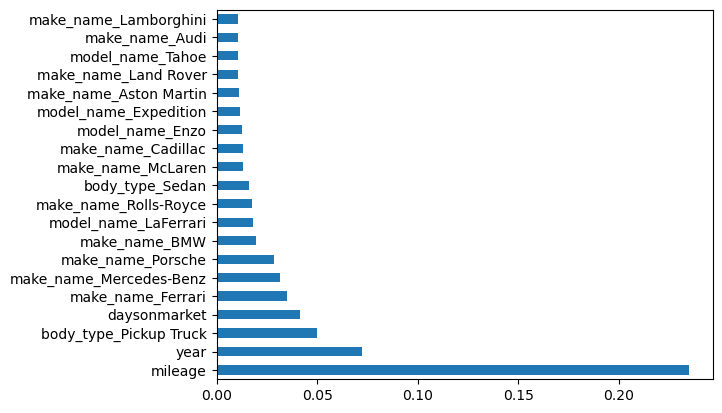

In [9]:
import matplotlib
feat_importances = pd.Series(used_car_predictor.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')


In [11]:
from sklearn.metrics import mean_squared_error
import numpy as np  # Import numpy for square root


# Predict on the test set
y_test_pred = used_car_predictor.predict(X_test)

# Calculate the MSE on the test set
mse_test = mean_squared_error(y_test, y_test_pred)

# Calculate the RMSE for the test set
rmse_test = np.sqrt(mse_test)

print(f'Root Mean Squared Error on Test Set: {rmse_test:.2f}')



Root Mean Squared Error on Test Set: 7756.50
